In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import mesa
from mesa.discrete_space import CellAgent, OrthogonalMooreGrid

In [3]:
class MoneyAgent(CellAgent):
    

    def __init__(self, model, cell):
        super().__init__(model)
        self.cell = cell  
        self.wealth = 1

    def move(self):
        self.cell = self.cell.neighborhood.select_random_cell()

    def give_money(self):
        cellmates = [
            a for a in self.cell.agents if a is not self
        ]
        if self.wealth > 0 and cellmates:
            other_agent = self.random.choice(cellmates)
            other_agent.wealth += 1
            self.wealth -= 1


class MoneyModel(mesa.Model):
    

    def __init__(self, n, width, height, seed=None):
        super().__init__(seed=seed)
        self.num_agents = n
        self.grid = OrthogonalMooreGrid((width, height), torus=True, random=self.random)

        agents = MoneyAgent.create_agents(
            self,
            self.num_agents,
            self.random.choices(self.grid.all_cells.cells, k=self.num_agents),
        )

    def step(self):
        self.agents.shuffle_do("move")
        self.agents.do("give_money")

In [4]:
model = MoneyModel(100, 10, 10)
for _ in range(20):
    model.step()
print(len(model.agents))


100


In [5]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.agents]
    x = sorted(agent_wealths)
    n = model.num_agents
    B = sum(xi * (n - i) for i, xi in enumerate(x)) / (n * sum(x))
    return 1 + (1 / n) - 2 * B


class MoneyAgent(CellAgent):

    def __init__(self, model, cell):
        super().__init__(model)
        self.cell = cell
        self.wealth = 1

    def move(self):
        self.cell = self.cell.neighborhood.select_random_cell()

    def give_money(self):
        cellmates = [a for a in self.cell.agents if a is not self]

        if self.wealth > 0 and cellmates:
            other_agent = self.random.choice(cellmates)
            other_agent.wealth += 1
            self.wealth -= 1


class MoneyModel(mesa.Model):

    def __init__(self, n, width, height, seed=None):
        super().__init__(seed=seed)
        self.num_agents = n
        self.grid = OrthogonalMooreGrid((width, height), torus=True, random=self.random)
        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )

        agents = MoneyAgent.create_agents(
            self,
            self.num_agents,
            self.random.choices(self.grid.all_cells.cells, k=self.num_agents),
        )

    def step(self):
        self.datacollector.collect(self)
        self.agents.shuffle_do("move")
        self.agents.do("give_money")

In [6]:
model = MoneyModel(100, 10, 10)
for _ in range(100):
    model.step()
    

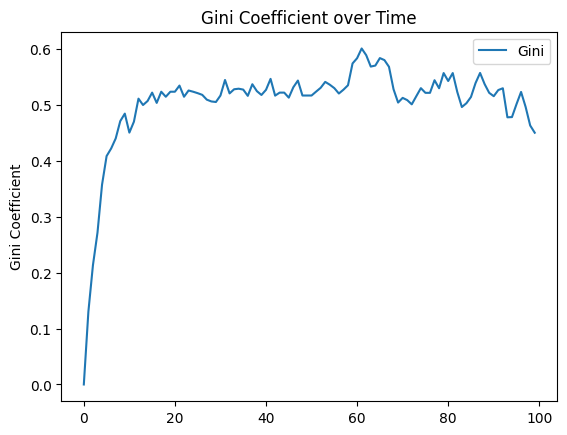

In [7]:
gini = model.datacollector.get_model_vars_dataframe()
g = sns.lineplot(data=gini)
g.set(title="Gini Coefficient over Time", ylabel="Gini Coefficient");

In [8]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head()

Wealth
Step AgentID        
1    1             1
     2             1
     3             1
     4             1
     5             1

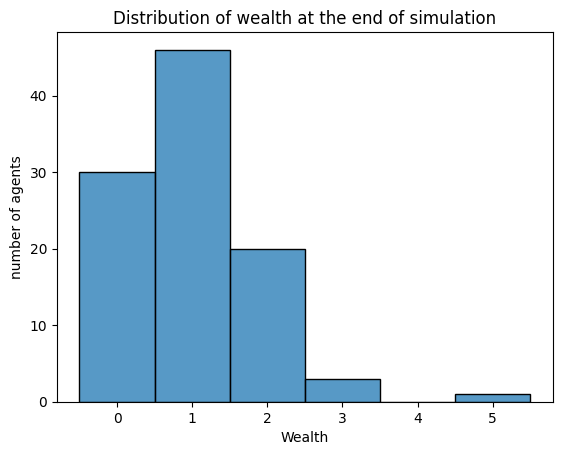

In [9]:
last_step = agent_wealth.index.get_level_values("Step").max()
end_wealth = agent_wealth.xs(last_step, level="Step")[
    "Wealth"
]
g = sns.histplot(end_wealth, discrete=True)
g.set(
    title="Distribution of wealth at the end of simulation",
    xlabel="Wealth",
    ylabel="number of agents",
);

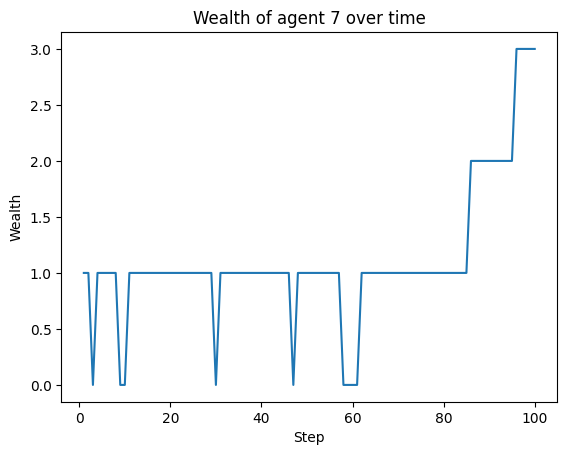

In [10]:
one_agent_wealth = agent_wealth.xs(7, level="AgentID")

g = sns.lineplot(data=one_agent_wealth, x="Step", y="Wealth")
g.set(title="Wealth of agent 7 over time");

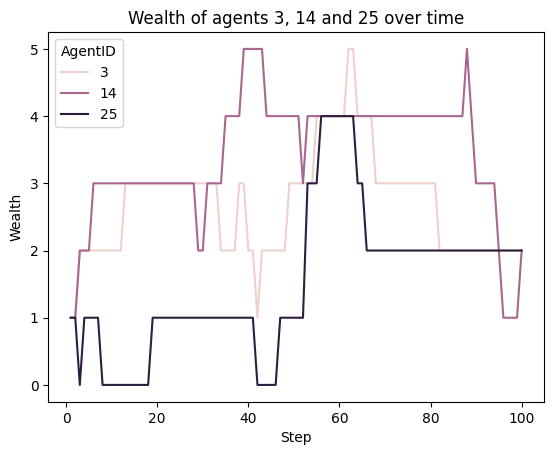

In [11]:
agent_list = [3, 14, 25]

multiple_agents_wealth = agent_wealth[
    agent_wealth.index.get_level_values("AgentID").isin(agent_list)
]
g = sns.lineplot(data=multiple_agents_wealth, x="Step", y="Wealth", hue="AgentID")
g.set(title="Wealth of agents 3, 14 and 25 over time");

[Text(0.5, 1.0, 'Average wealth over time')]

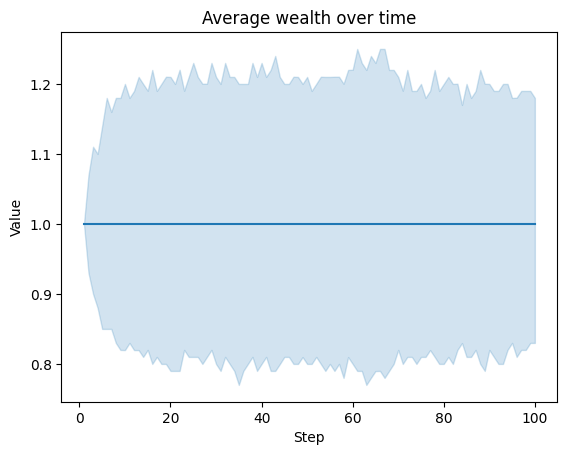

In [12]:
agent_wealth_long = agent_wealth.T.unstack().reset_index()
agent_wealth_long.columns = ["Step", "AgentID", "Variable", "Value"]
agent_wealth_long.head(3)

g = sns.lineplot(data=agent_wealth_long, x="Step", y="Value", errorbar=("ci", 95))
g.set(title="Average wealth over time")

In [13]:
gini.to_csv("model_data.csv")

agent_wealth.to_csv("agent_data.csv")